5964.741809489781 5964.741809489789


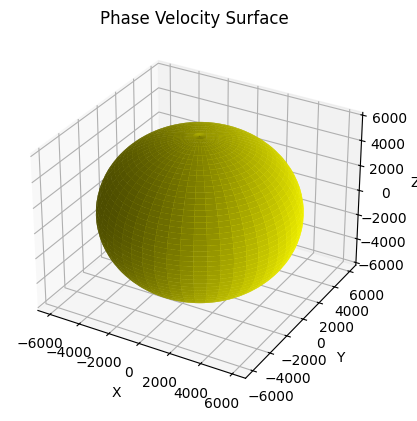

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def voigt_to_tensor(C_voigt):
    """
    Convert a stiffness tensor from Voigt notation (6x6) to full tensor form (3x3x3x3).
    """
    voigt_map = [
        (0, 0), (1, 1), (2, 2), (1, 2), (0, 2), (0, 1)
    ]
    C_tensor = np.zeros((3, 3, 3, 3))

    for i in range(6):
        for j in range(6):
            ii, jj = voigt_map[i]
            kk, ll = voigt_map[j]
            # Symmetric tensor assignment
            C_tensor[ii, jj, kk, ll] = C_voigt[i, j]
            C_tensor[jj, ii, kk, ll] = C_voigt[i, j]
            C_tensor[ii, jj, ll, kk] = C_voigt[i, j]
            C_tensor[jj, ii, ll, kk] = C_voigt[i, j]
    return C_tensor

# Isotropic material stiffness tensor in Voigt notation (6x6)
C_voigt = np.array([
    [280e9, 120e9, 120e9, 0, 0, 0],
    [120e9, 280e9, 120e9, 0, 0, 0],
    [120e9, 120e9, 280e9, 0, 0, 0],
    [0, 0, 0, 80e9, 0, 0],
    [0, 0, 0, 0, 80e9, 0],
    [0, 0, 0, 0, 0, 80e9]
])


# Define density in kg/m^3
rho = 7870

# Convert Voigt notation to full tensor
C_tensor = voigt_to_tensor(C_voigt)

# Define polar and azimuthal angles for propagation direction
theta = np.linspace(0, np.pi, 200)  # Polar angle (0 to π)
phi = np.linspace(0, 2 * np.pi, 200)  # Azimuthal angle (0 to 2π)

# Initialize array for wave speeds
wave_speeds = np.zeros((len(theta), len(phi)))

# Compute wave speeds for each propagation direction
for i, t in enumerate(theta):
    for j, p in enumerate(phi):
        # Direction vector in spherical coordinates
        n = np.array([np.sin(t) * np.cos(p), np.sin(t) * np.sin(p), np.cos(t)])

        # Compute Christoffel tensor: Γ = C_ijkl * n_i * n_j
        Gamma = np.einsum('ilkj,k,l->ij', C_tensor, n, n)

        # Divide by density
        Gamma_reduced = Gamma / rho  # Assume density is defined, e.g., density = 2700 kg/m³

        # Compute eigenvalues of Christoffel tensor
        eigenvalues = np.linalg.eigvalsh(Gamma_reduced)

        # Maximum eigenvalue corresponds to fastest phase velocity
        wave_speeds[i, j] = np.sqrt(np.max(eigenvalues))

print(np.min(wave_speeds), np.max(wave_speeds))

# Convert wave speeds to Cartesian coordinates for visualization
X = wave_speeds * np.sin(theta)[:, None] * np.cos(phi)
Y = wave_speeds * np.sin(theta)[:, None] * np.sin(phi)
Z = wave_speeds * np.cos(theta)[:, None]

# Plot the phase velocity surface with a solid yellow color
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface with no color map, just solid yellow
surface = ax.plot_surface(X, Y, Z, color='yellow', edgecolor='none')

# Add labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.title('Phase Velocity Surface')
plt.show()

In [2]:
import numpy as np

# Compute gradients of wave speeds in spherical coordinates
dtheta = np.gradient(theta)  # Spacing in theta
dphi = np.gradient(phi)  # Spacing in phi

# Gradient with respect to theta (rows)
grad_theta = np.gradient(wave_speeds, axis=0) / dtheta[:, None]

# Gradient with respect to phi (columns)
grad_phi = np.gradient(wave_speeds, axis=1) / dphi

# Calculate group velocity components
def compute_group_velocity(wave_speeds, grad_theta, grad_phi, theta, phi):
    v_r = wave_speeds  # Radial component (same as wave speeds)
    v_theta = grad_theta  # Polar component
    v_phi = grad_phi / np.sin(theta)[:, None]  # Azimuthal component

    return v_r, v_theta, v_phi

# Compute magnitudes and angles
def compute_angle_between_velocities(wave_speeds, grad_theta, grad_phi, theta, phi):
    v_r, v_theta, v_phi = compute_group_velocity(wave_speeds, grad_theta, grad_phi, theta, phi)

    # Group velocity magnitude
    v_group_magnitude = np.sqrt(v_r**2 + v_theta**2 + v_phi**2)

    # Phase velocity magnitude
    v_phase_magnitude = wave_speeds

    # Dot product of phase and group velocities
    dot_product = v_r * wave_speeds  # Only radial component contributes to the dot product

    # Cosine of the angle
    cos_alpha = dot_product / (v_phase_magnitude * v_group_magnitude)

    # Avoid numerical errors
    cos_alpha = np.clip(cos_alpha, -1.0, 1.0)

    # Angle in radians
    alpha = np.arccos(cos_alpha)
    return alpha

# Compute the angles
angles = compute_angle_between_velocities(wave_speeds, grad_theta, grad_phi, theta, phi)

# Convert to degrees for readability
angles_degrees = np.degrees(angles)

# Example: Print angle at a specific point
print("Angle (in degrees) at (theta=pi/2, phi=pi):", angles_degrees[50, 50])

Angle (in degrees) at (theta=pi/2, phi=pi): 0.0


<ipython-input-2-93833546f55f>:17: RuntimeWarning: invalid value encountered in divide
  v_phi = grad_phi / np.sin(theta)[:, None]  # Azimuthal component
